In [468]:
from covid_api import CovidAPI, APIHelper
from datetime import datetime
from scipy import stats
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [927]:
def load_csv(file_name):
    return pd.read_csv('../data/' + file_name)

df_countries_and_continents = load_csv('country-and-continent-codes-list-csv_csv.csv')
del df_countries_and_continents['Unnamed: 0']

df_covid_cases = load_csv('covid_cases.csv')
df_covid_cases['date'] = pd.to_datetime(df_covid_cases['date'])
del df_covid_cases['Unnamed: 0']

covid_summaries = load_csv('covid_summaries.csv')
del covid_summaries['Unnamed: 0']

df_owid_covid = load_csv('owid_covid_data.csv')
del df_owid_covid['Unnamed: 0']
del df_owid_covid['Unnamed: 0.1']

### plotbars with death, confirmed and recovered count
 

In [423]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y %m')

plt.style.use('seaborn-whitegrid')
def covid_lineplot(covid_deaths, covid_confirmed, covid_recovered):
    fig, ax = plt.subplots()

    ax.plot(covid_deaths, color='black')
    ax.plot(covid_confirmed)
    ax.plot(covid_recovered)

    #ax.legend((l2, l4), ('oscillatory', 'damped'), loc='upper right', shadow=True)
    ax.legend(('oscillatory', 'damped', 'dsadad'),fontsize=15)

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years.
    covid_recovered.index[-1]
    datemin = np.datetime64(covid_recovered.index[0], 'Y')
    datemax = np.datetime64(covid_recovered.index[-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)

    ax.set_title('Default Date Formatter',fontsize=15)
    ax.set_xlabel('common xlabel',fontsize=15)
    ax.set_ylabel('common ylabel',fontsize=15)
    #ax.set_yticks(np.arange(0, 50000000, 5000000))
    
    import datetime as dt
    plt.axvline(dt.datetime(2020, 3, 11),color='black',linestyle='--')
    x_text_annotation = dt.datetime(2020, 3, 11)
    #ax.text(x=x_text_annotation, y=40000000, s='WHO declared covid as pandemic', color='#334f8d',fontsize=15)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    fig.set_size_inches(15.5, 10.5)

    plt.show()


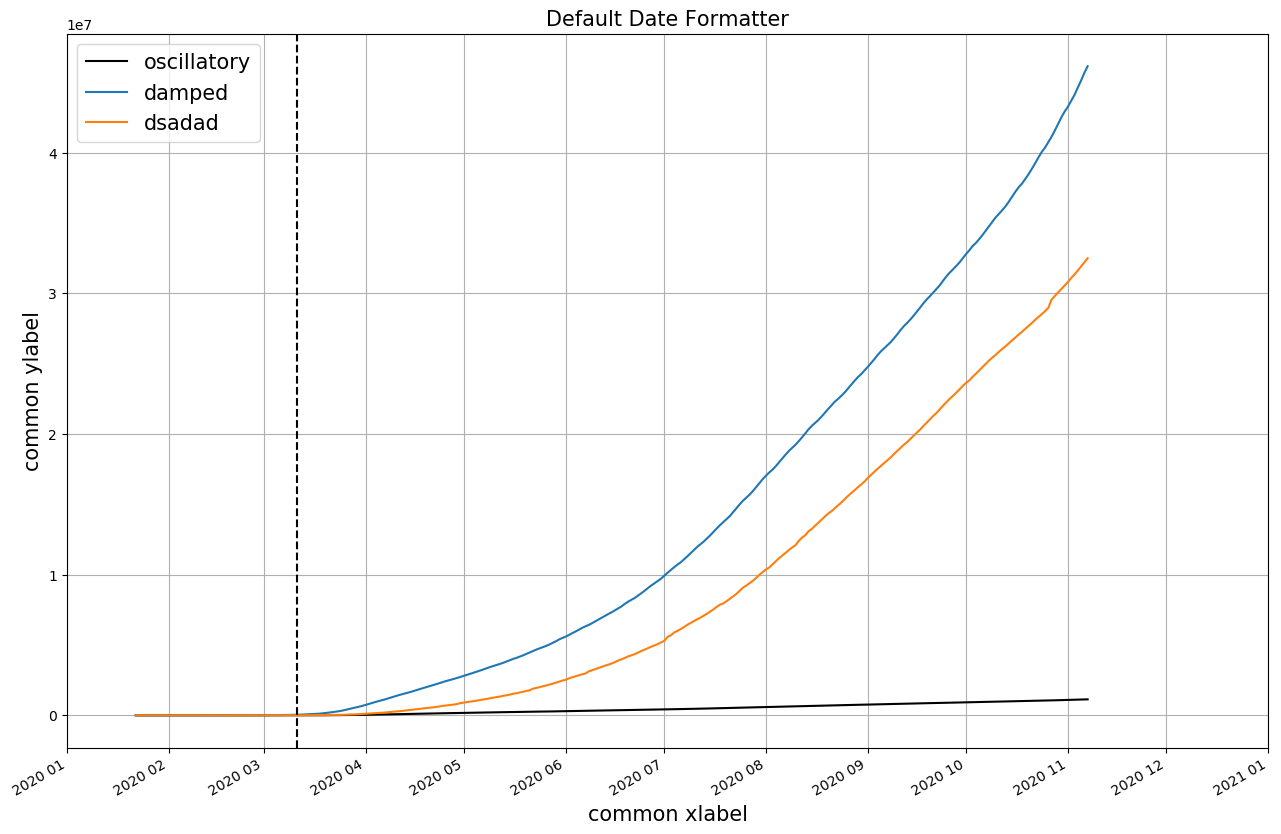

In [880]:
covid_by_date = df_covid_cases.groupby('date').sum()
covid_deaths = covid_by_date.deaths
covid_confirmed = covid_by_date.confirmed
covid_recovered = covid_by_date.recovered

covid_lineplot(covid_deaths, covid_confirmed, covid_recovered)

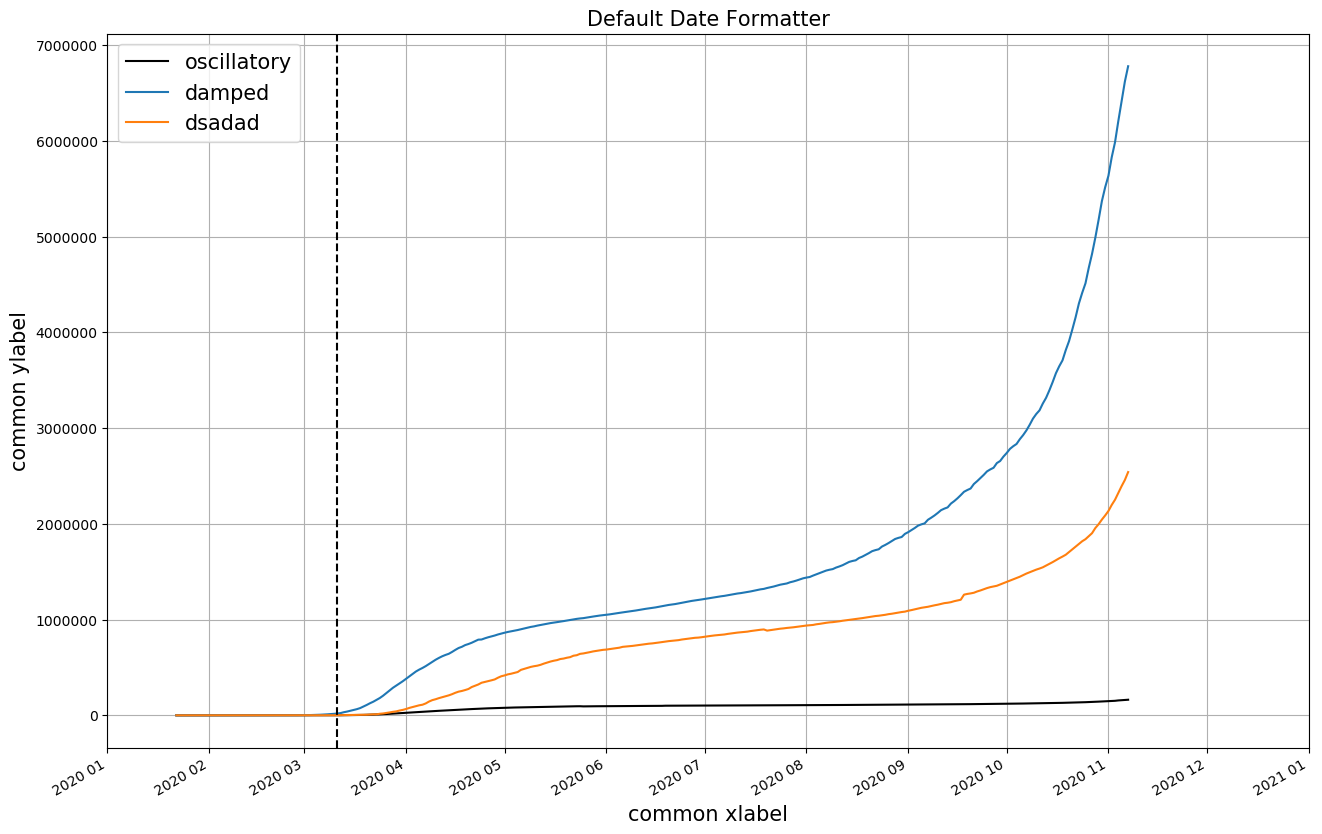

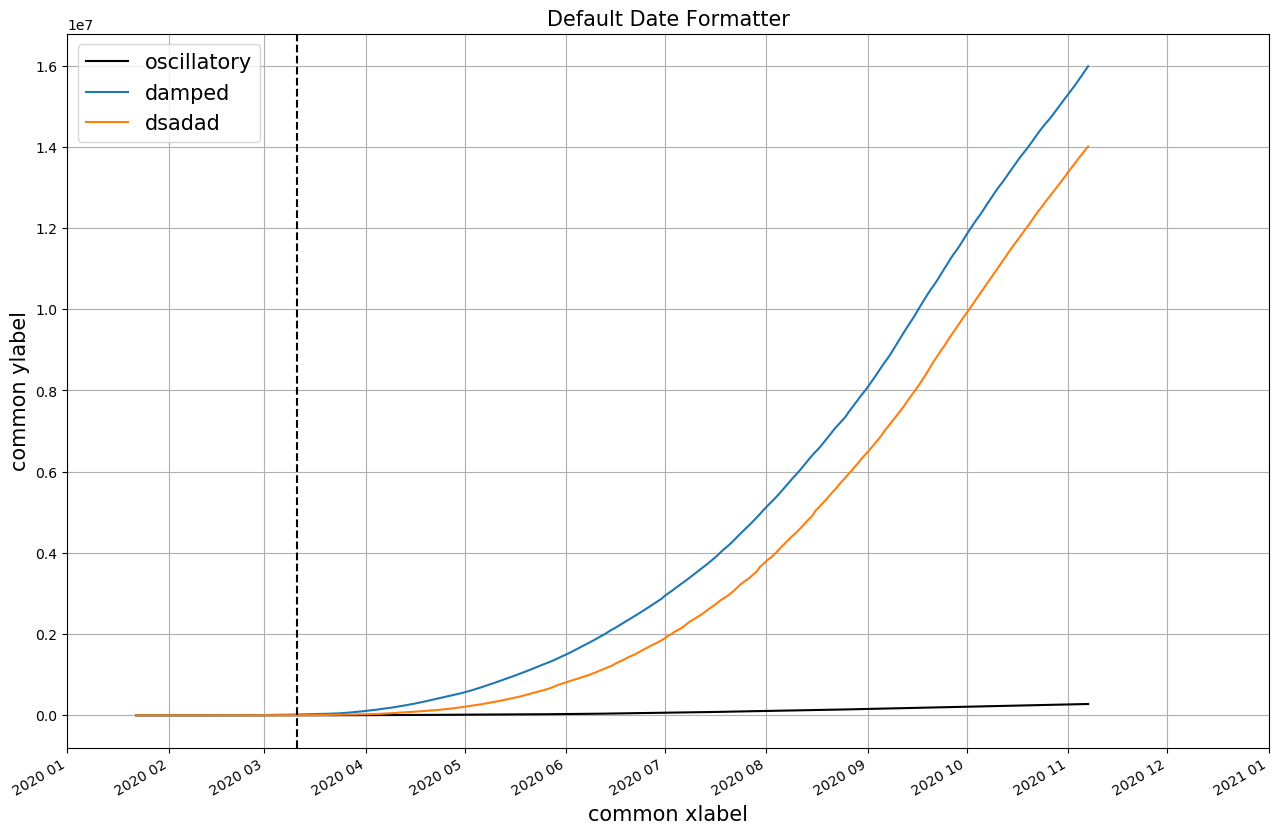

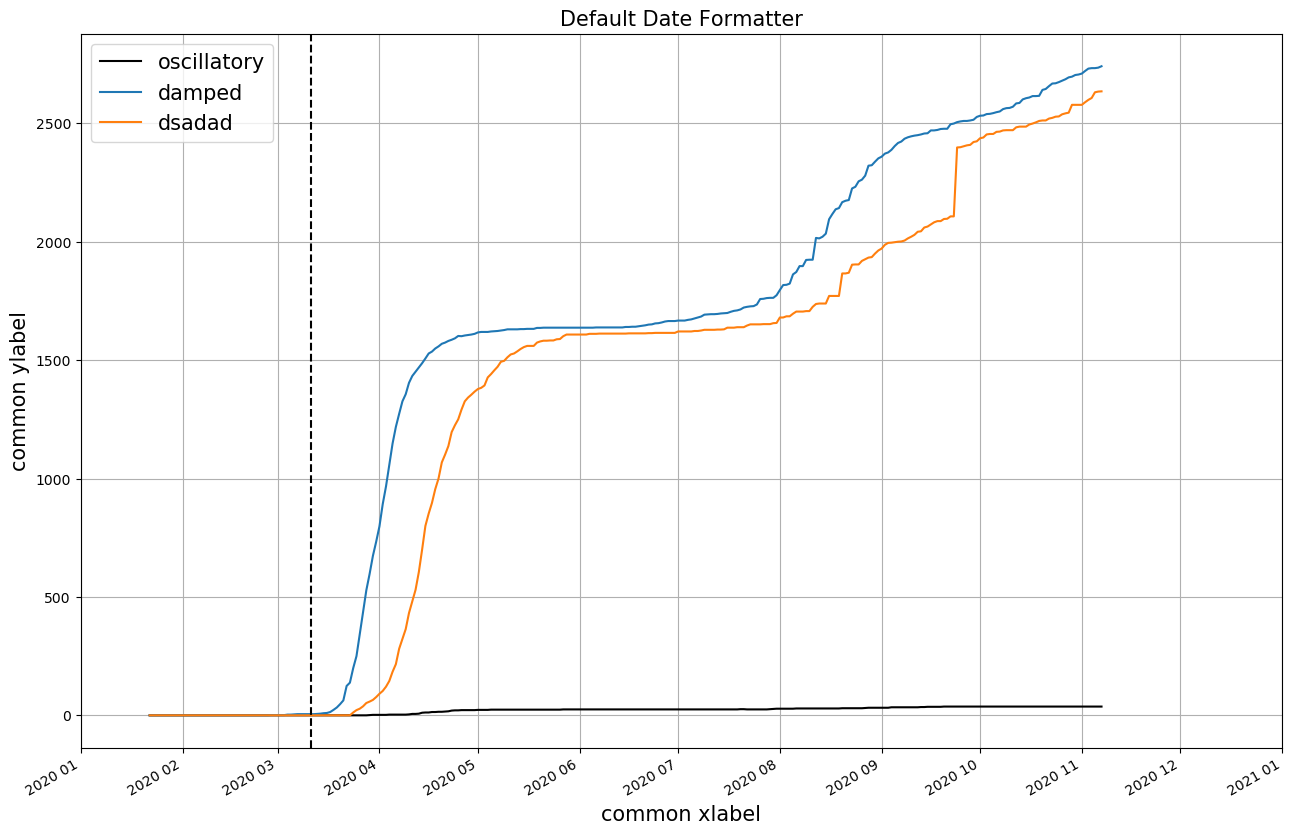

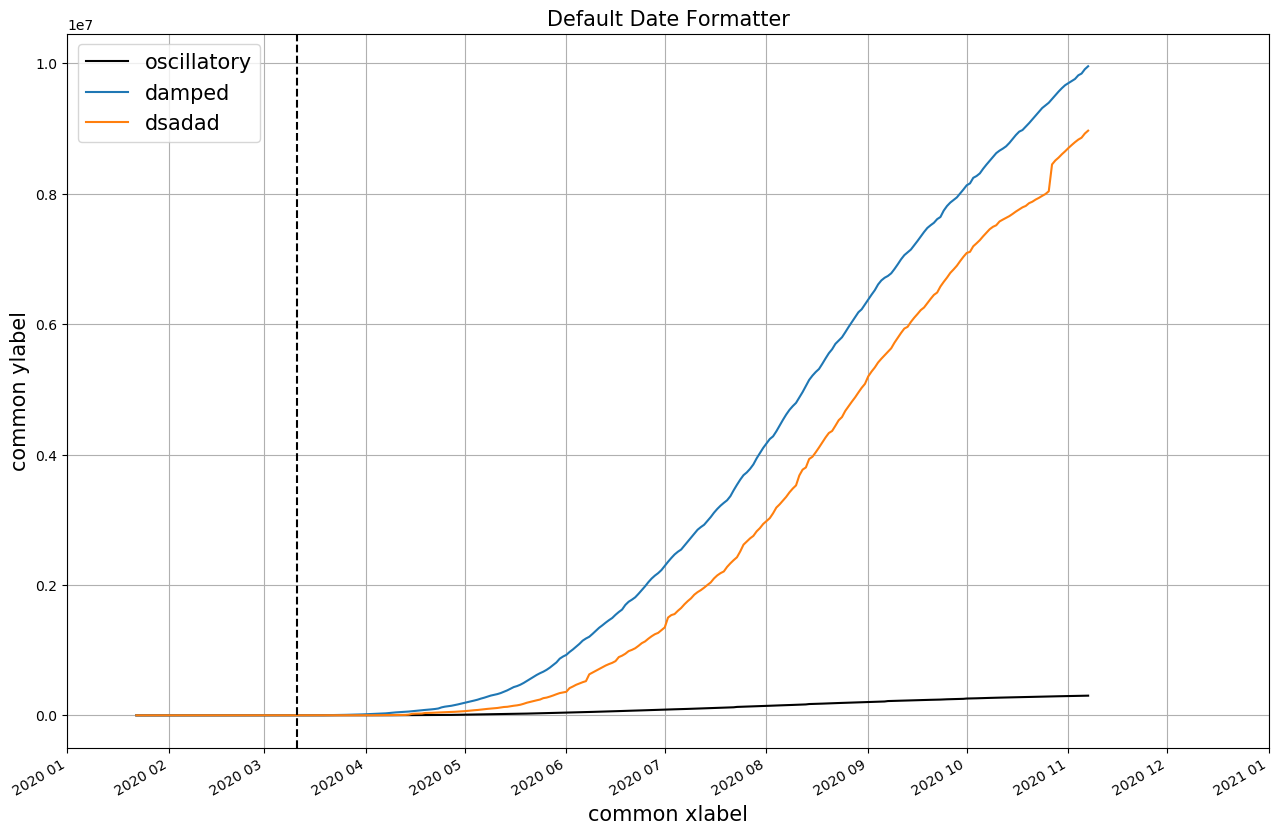

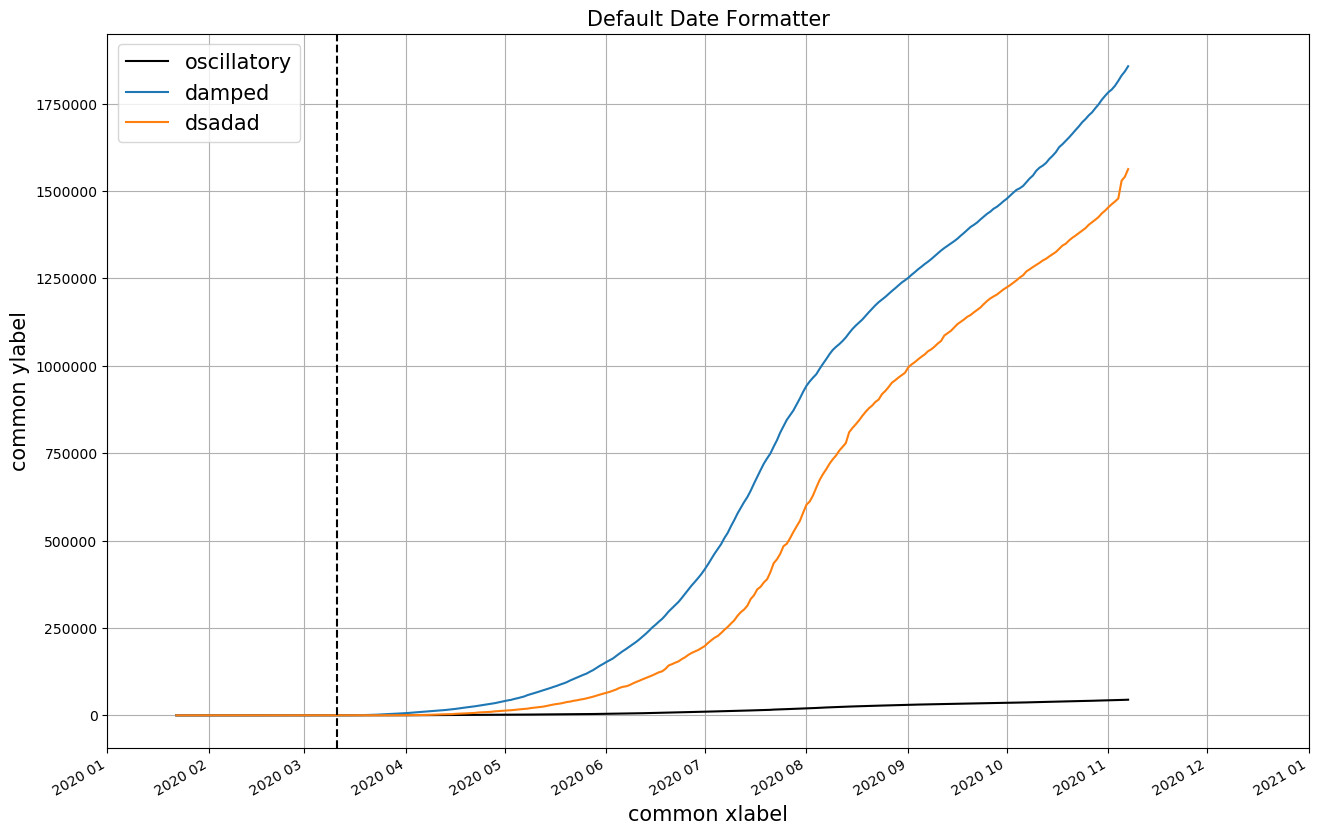

In [883]:
for c in list(set(df_covid_cases.continent_code.dropna())):
    df_covid_cases_per_continent = df_covid_cases[df_covid_cases.continent_code == c]
    covid_by_date = df_covid_cases_per_continent.groupby('date').sum()
    covid_deaths = covid_by_date.deaths
    covid_confirmed = covid_by_date.confirmed
    covid_recovered = covid_by_date.recovered
    
    covid_lineplot(covid_deaths, covid_confirmed, covid_recovered)

### top N countries with higher death, confirmed and recovered count

In [ ]:
def bar_plot(df, sort_key, first_n):
    df_p_c = df.sort_values([sort_key], ascending=False)[:first_n]
    objects = df_p_c.country_code.tolist()
    y_pos = np.arange(len(objects))
    performance = df_p_c[sort_key].tolist()
    
    plt.bar(y_pos, performance, align='center', alpha=0.5,color='b')

    plt.xticks(y_pos, objects)
    plt.ylabel('Usage')
    plt.xlabel('meh')
    plt.title(sort_key)

    plt.show()

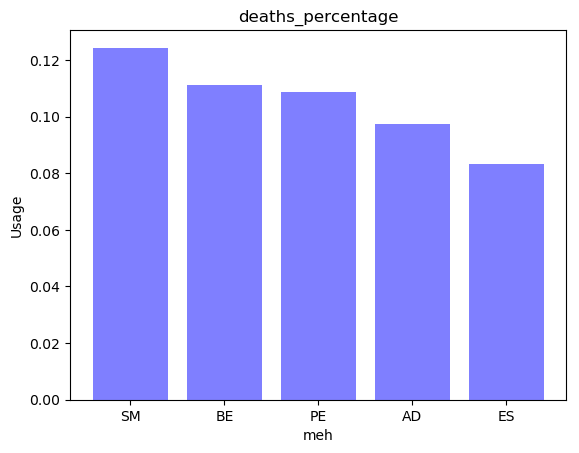

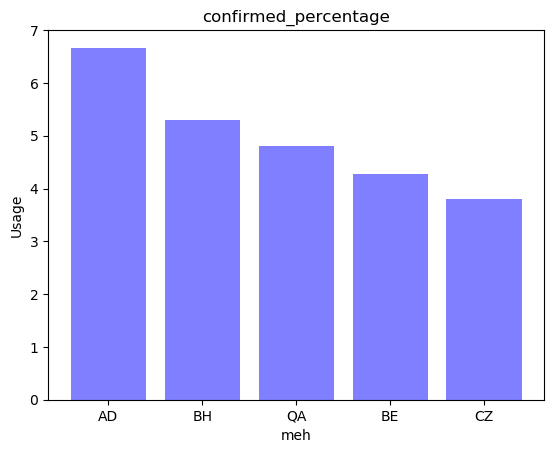

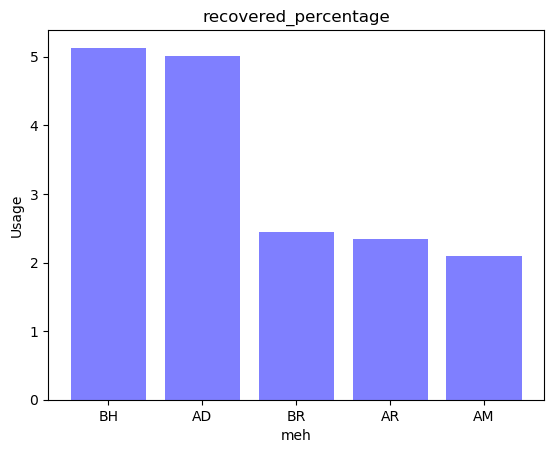

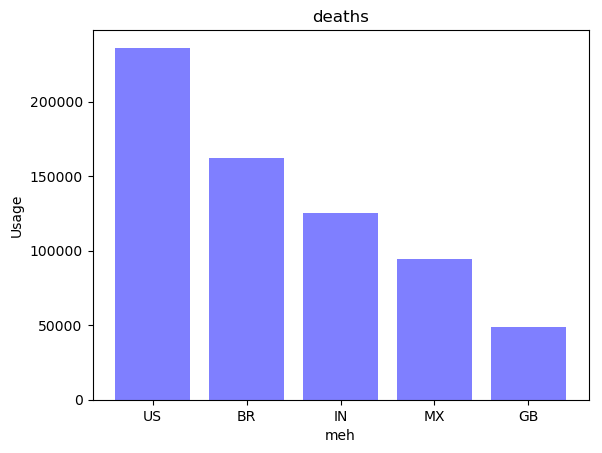

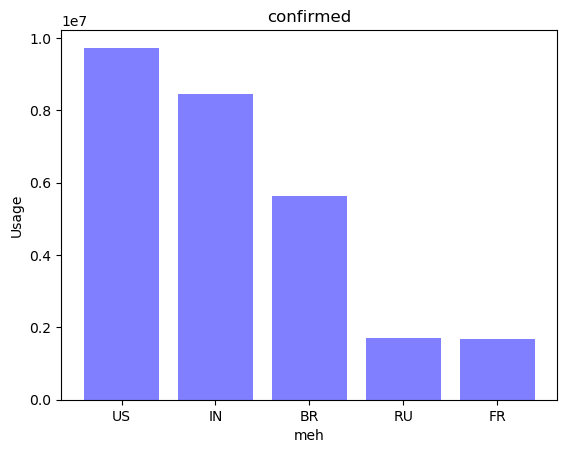

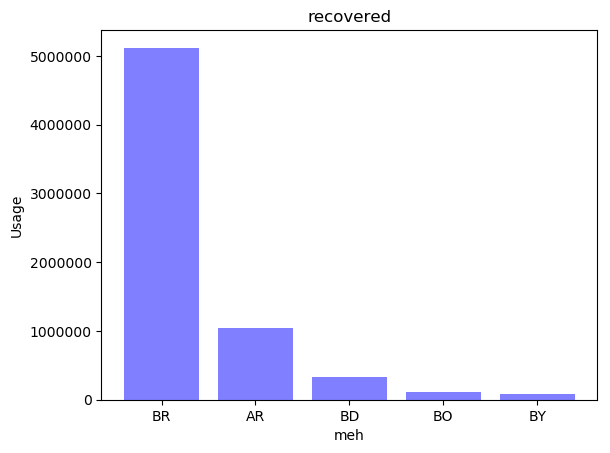

In [451]:

keys = ['deaths_percentage', 'confirmed_percentage', 'recovered_percentage', 'deaths', 'confirmed', 'recovered']
for k in keys:
    bar_plot(covid_summaries, k, first_n=5)

### deaths, recovered and confirmed around the world

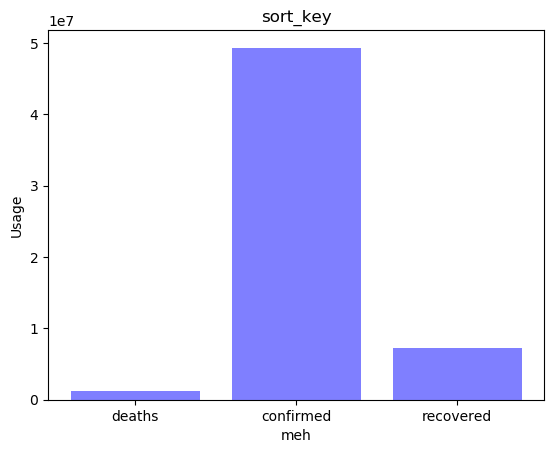

In [463]:
resp_latest = CovidAPI.get_task('/v2/latest')['latest']
objects = ['deaths', 'confirmed', 'recovered']
y_pos = np.arange(len(objects))
performance = [resp_latest['deaths'], resp_latest['confirmed'], resp_latest['recovered']]

plt.bar(y_pos, performance, align='center', alpha=0.5,color='b')

plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.xlabel('meh')
plt.title('sort_key')

plt.show()

# Looking for correlation 

In [834]:
def get_column(A, j): 
    return A.iloc[:,j]


def scatter_list(df_corr, fixed_column, figsize, threshold):
    _, num_columns = df_corr.shape
    fig, ax = plt.subplots(1, num_columns, figsize = figsize) 
    columns = df_corr.columns.values
    ax[0].set_ylabel(fixed_column.columns.values[0], fontsize=14)
    
    for i in range(num_columns):
        
        corr_column = get_column(df_corr, i)
        aux = pd.DataFrame()
        aux['corr_column'] = corr_column
        aux['fixed_column'] = fixed_column
        aux.dropna()
        
        #remove outliers
        q = aux['fixed_column'].quantile(threshold)
        aux = aux[aux['fixed_column'] < q]

        ax[i].scatter(aux['corr_column'], aux['fixed_column'], alpha=0.15, c='blue')
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)
        ax[i].set_xlabel(columns[i], fontsize=14)

    plt.show()
    
def chunk(lst, n):
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [928]:

fixed_columns_names = ['deaths','confirmed','recovered']
fixed_columns = []

for fixed_col in fixed_columns_names:
    fixed_columns.append(df_owid_covid.filter([fixed_col], axis=1))

for i in fixed_columns_names:
    del df_owid_covid[i]

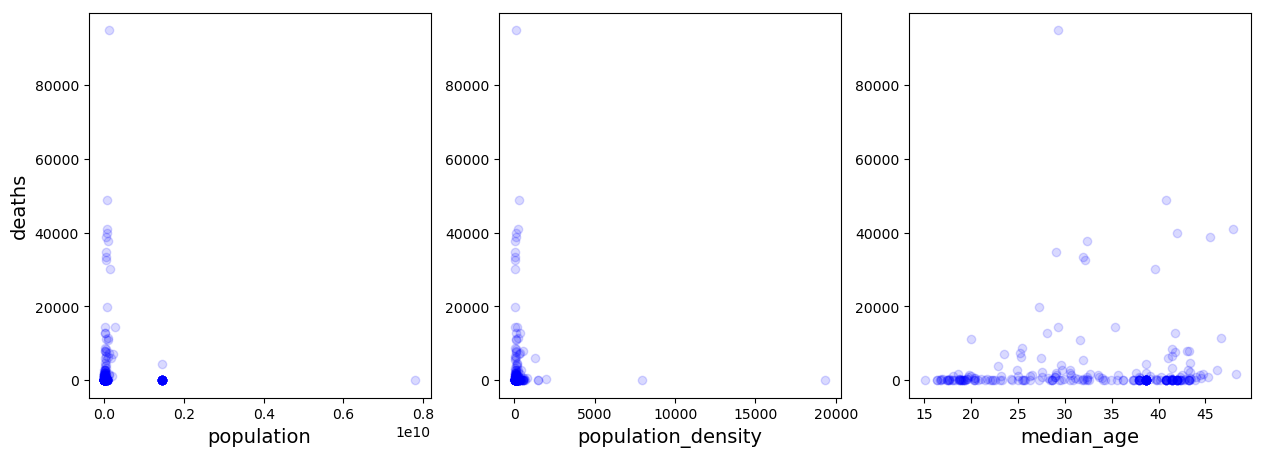

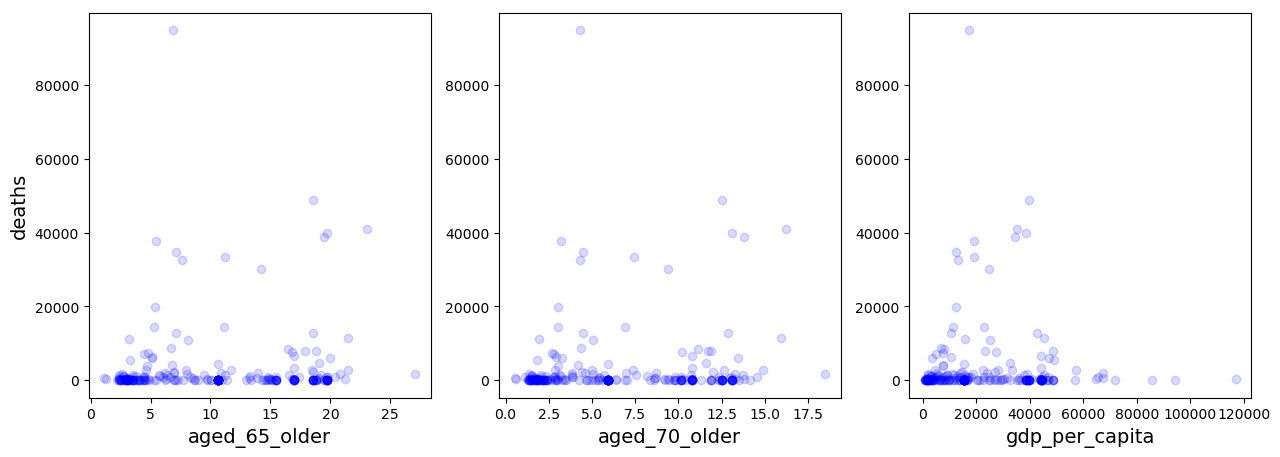

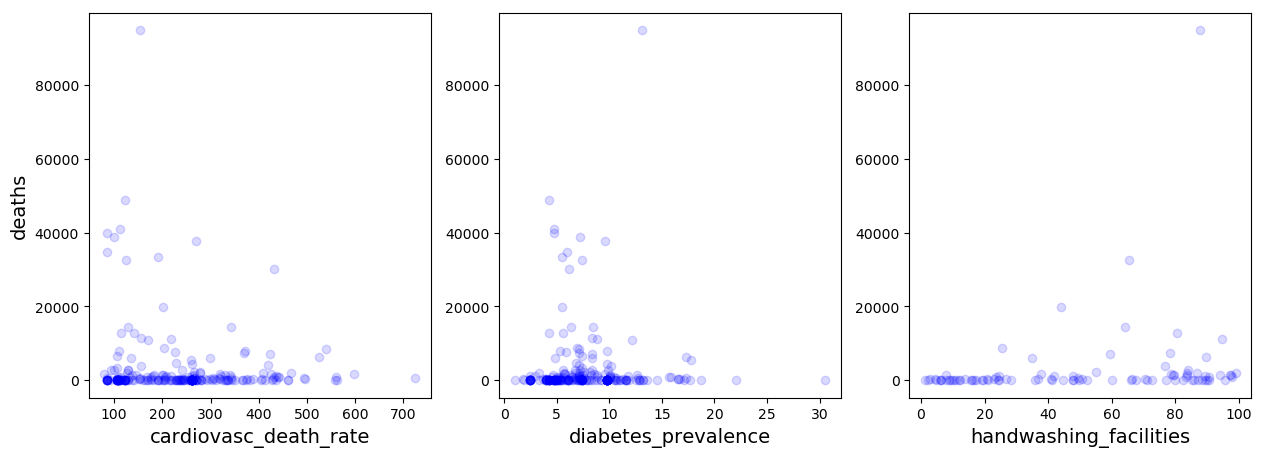

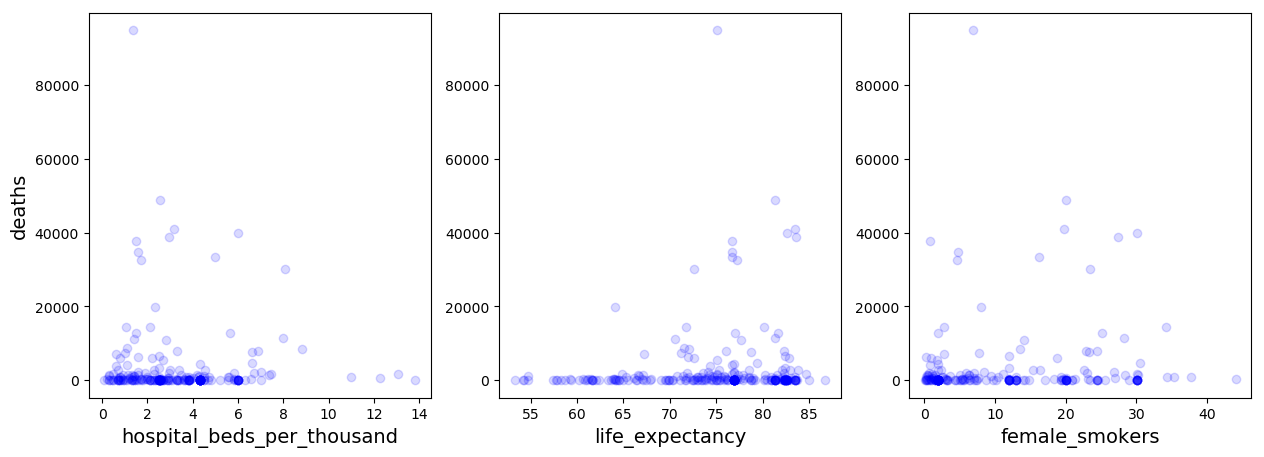

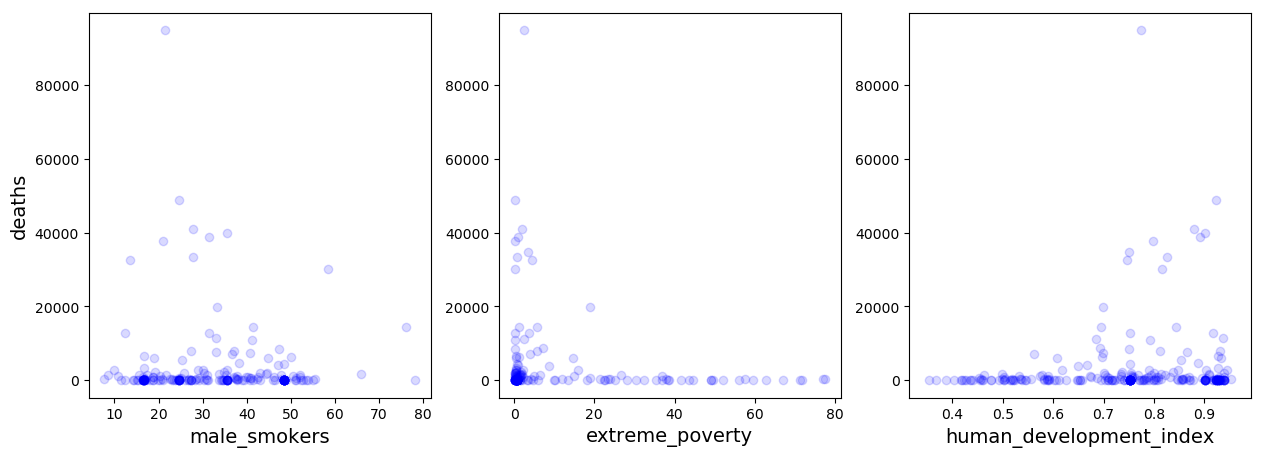

In [931]:
for sub_arr in chunk(df_owid_covid.columns.tolist()[1:], 3):
    aux = df_owid_covid.filter(sub_arr)
    _, num_columns = aux.shape
    w = 5
    scatter_list(aux, fixed_columns[0], figsize=(w * num_columns, w), threshold=.99)

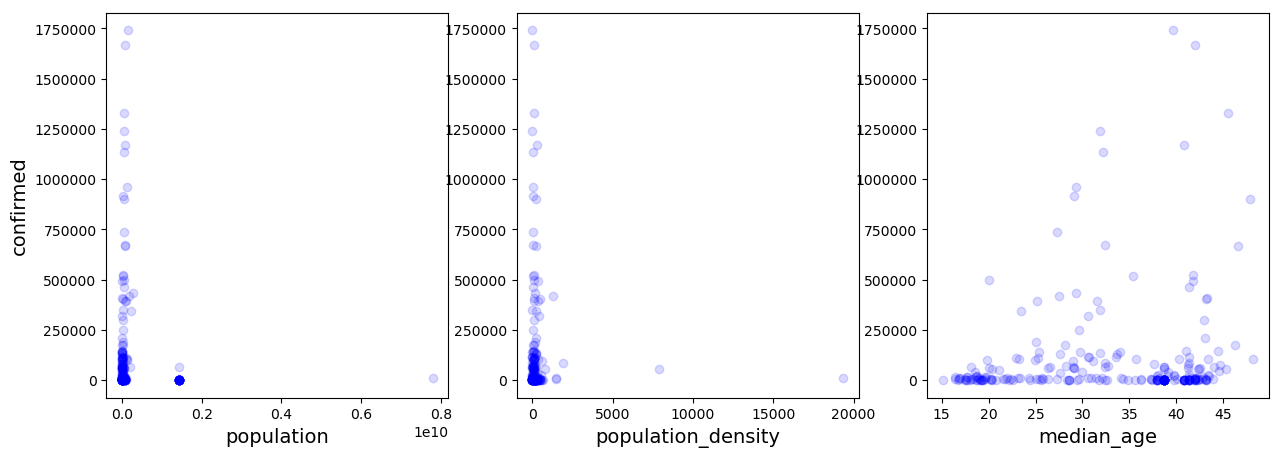

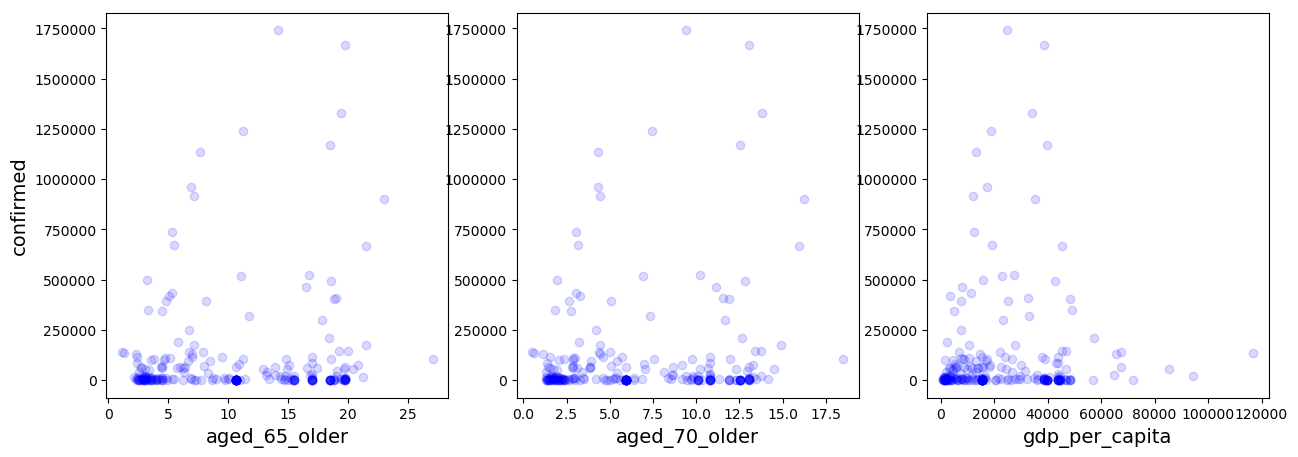

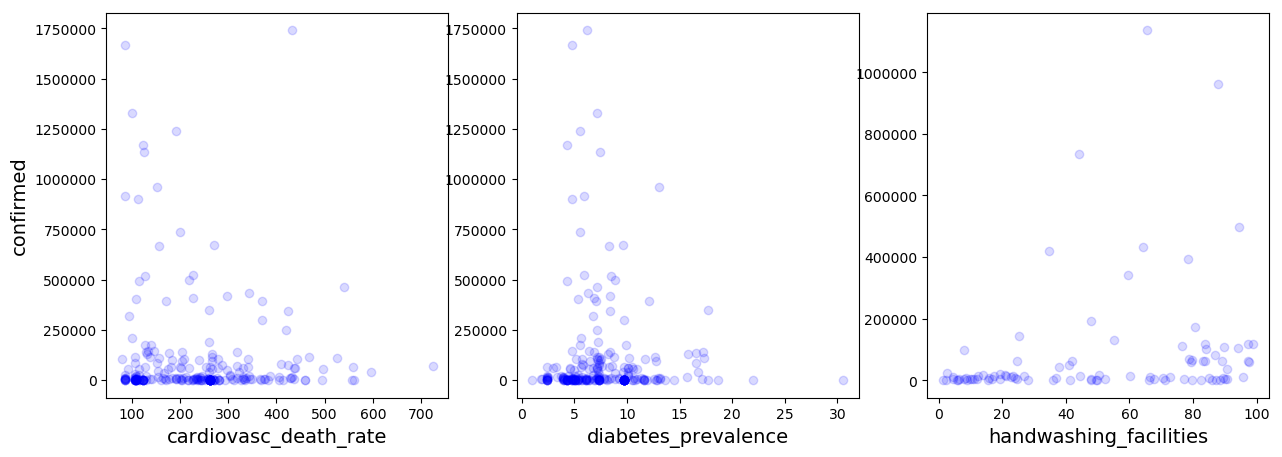

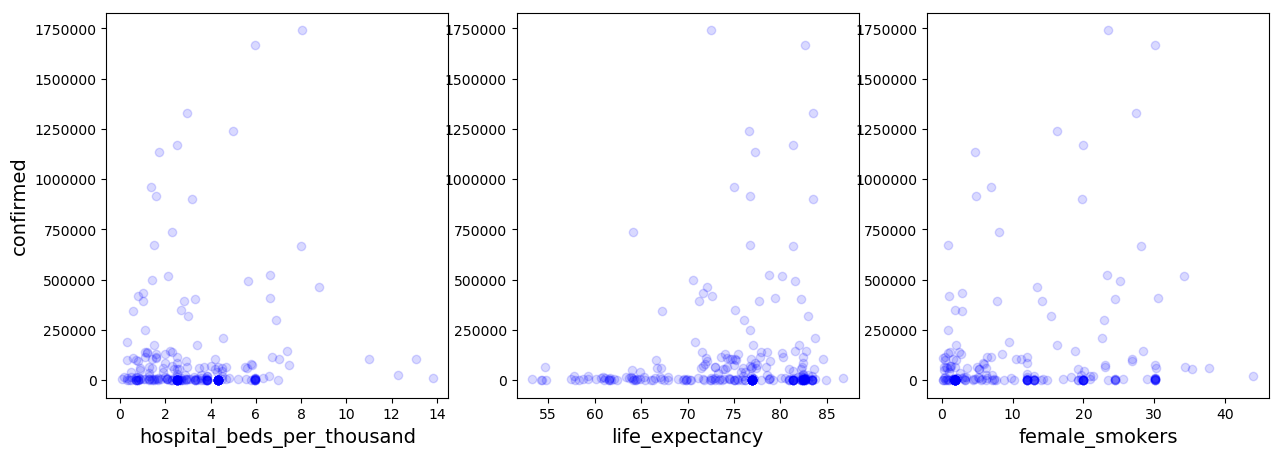

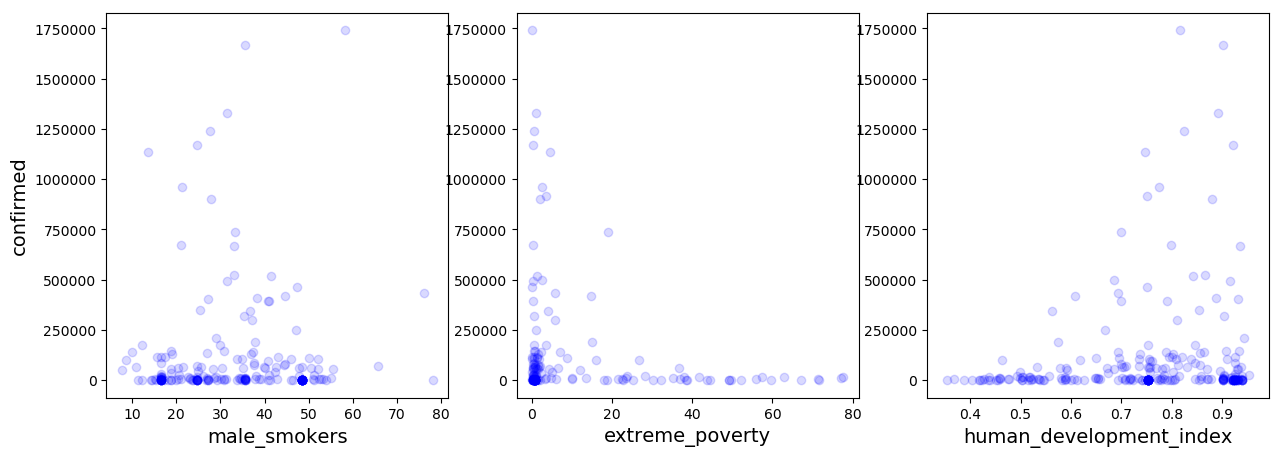

In [899]:
for sub_arr in chunk(df_owid_covid.columns.tolist()[1:], 3):
    aux = df_owid_covid.filter(sub_arr)
    _, num_columns = aux.shape
    w = 5
    scatter_list(aux, fixed_columns[1], figsize=(w * num_columns, w), threshold=.99)



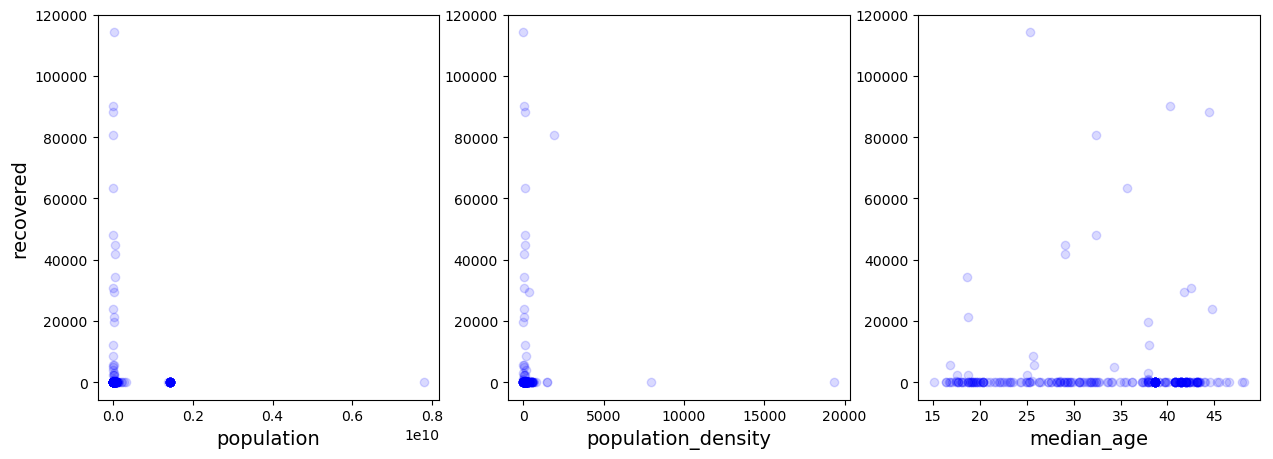

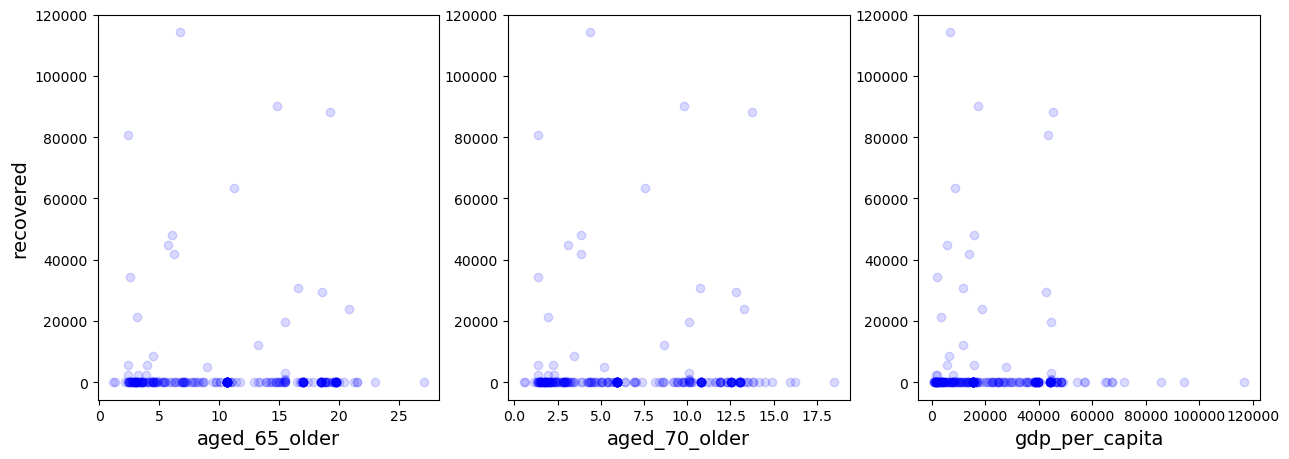

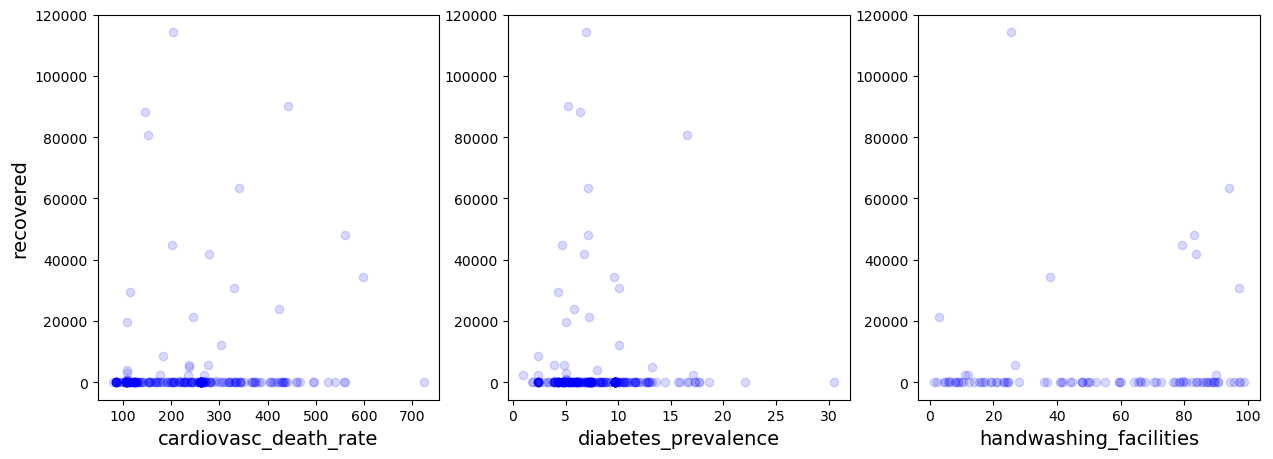

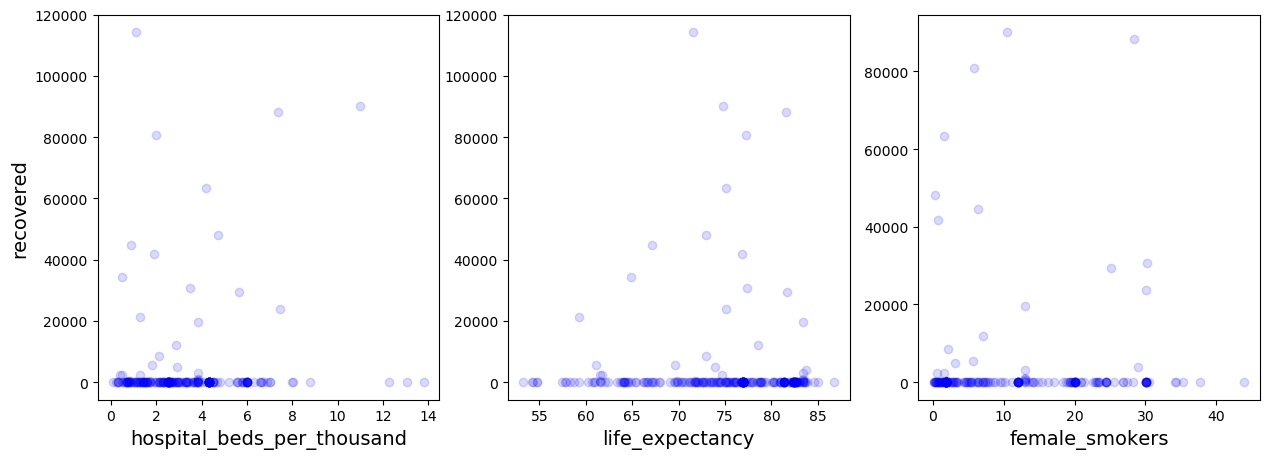

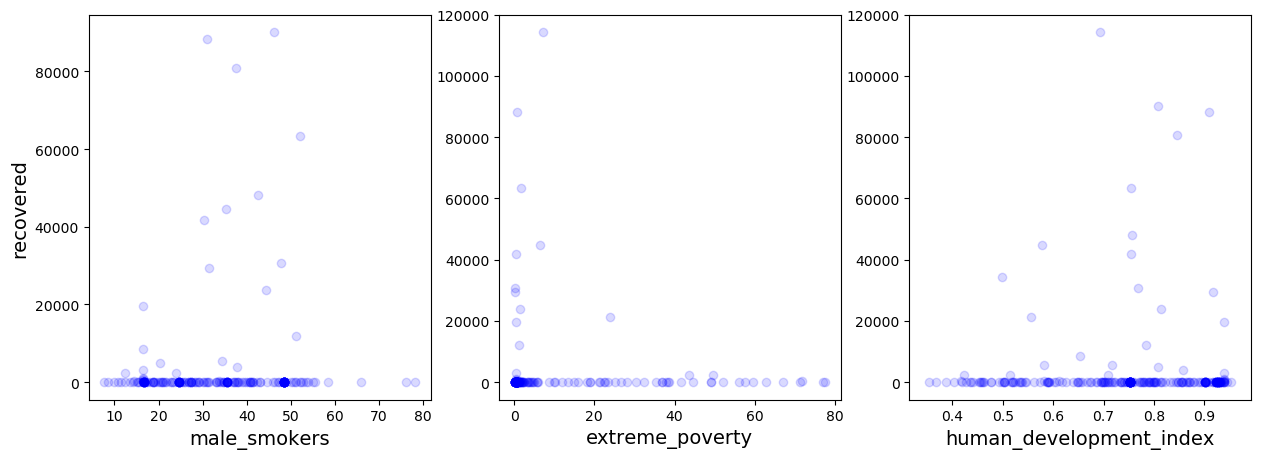

In [900]:
for sub_arr in chunk(df_owid_covid.columns.tolist()[1:], 3):
    aux = df_owid_covid.filter(sub_arr)
    _, num_columns = aux.shape
    w = 5
    scatter_list(aux, fixed_columns[2], figsize=(w * num_columns, w), threshold=.99)



# heatmap 

In [777]:
def heatmap(df_corr, fixed_column, figsize, threshold):    
    plt.figure(figsize=figsize)
    sns.heatmap(df_corr, annot=True, fmt='.2f')#,cmap='summer', center=0.5);
    

In [929]:
df_owid_covid_ = pd.merge(df_owid_covid, covid_summaries, on='country_code', how='inner')
del df_owid_covid_['deaths_percentage']
del df_owid_covid_['confirmed_percentage']
del df_owid_covid_['recovered_percentage']

for c in df_owid_covid_.columns:
    if c != 'country_code':
        df_owid_covid_[c] = pd.to_numeric(df_owid_covid_[c])
    
df_owid_covid_ = df_owid_covid_.corr()
df_owid_covid_.drop(df_owid_covid_.head(-3).index,inplace=True)

del df_owid_covid_['deaths']
del df_owid_covid_['confirmed']
del df_owid_covid_['recovered']

df_owid_covid_

,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,female_smokers,male_smokers,extreme_poverty,human_development_index
deaths,-0.13048,-0.00007,-0.02292,0.07267,0.09195,0.08762,-0.10151,-0.07962,0.14239,-0.08343,0.03201,0.14621,-0.12322,0.02471,0.07945
confirmed,-0.11001,0.00570,-0.03163,0.05553,0.07260,0.07478,-0.07434,-0.06237,0.07597,-0.05620,0.01192,0.13583,-0.10288,0.04596,0.05719
recovered,-0.03456,-0.00339,-0.04351,-0.02884,-0.02184,-0.01938,-0.00882,-0.01043,-0.01268,-0.03404,-0.01895,0.01153,-0.04490,0.00961,-0.01112


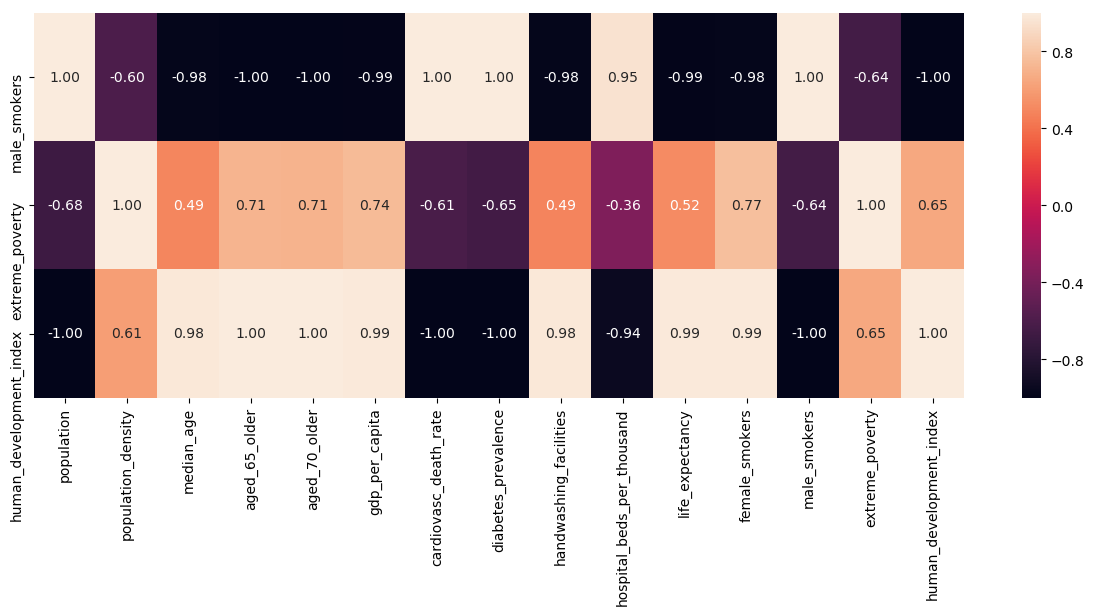

In [930]:
plt.figure(figsize=(15,5))
sns.heatmap(t, annot=True, fmt='.2f')#,cmap='summer', center=0.5);